# Exploring venues in Chandigarh, India

In this notebook, I'll explore various venues in the city of **Chandigarh** in India. I'll use the **Foursquare API** to fetch location information of various venues. Then, I'll retrieve the ratings and prices of these venues using **Zomato API**.

## Import libraries

The first step is to import all the necessary libraries that will be needed to read the location data and use APIs to retrieve information.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium
import requests
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim

Next, I'll define various constants I'll access throughout the notebook as well as save the authorization keys for both APIs inside constants for easy access.

In [69]:
NO_OF_VENUES = 100
RADIUS = 4000
NO_OF_CLUSTERS = 2
FOURSQUARE_CLIENT_ID = '0HH2B0MRFB2FALD3CL3SQAGF5KPCVO53DS5OEOKOP4MWUCJO'
FOURSQUARE_CLIENT_SECRET = 'D5KMPZK1RAFC0RSUS3VCUOIAIIA2KVCOWHIP1RJX3D1L0UQS'
VERSION = '20190610' # Current date
ZOMATO_API_KEY = 'b3a1c26ed20422bfaae7ada558744e1f'

## Chandigarh

The first step is to take a look at the location **Chandigarh** on the map. Let's use `Nominatim` to get the latitude and longitude value of the city.

In [70]:
address = 'Chandigarh, India'

geolocator = Nominatim(user_agent = "chandigarh")
location = geolocator.geocode(address)
CHD_LATITUDE = location.latitude
CHD_LONGITUDE = location.longitude
print('The geograpical coordinates of Chandigarh are {}, {}.'.format(CHD_LATITUDE, CHD_LONGITUDE))

The geograpical coordinates of Chandigarh are 30.7194022, 76.7646552.


I'll take a look **Chandigarh** on a map as well.

In [71]:
chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 12)
chandigarh_map

**Chandigarh** is composed of a number of sectors spread across a total area of 114 sq Km. There are many venues (especially restaurants, hotels and cafes) which we can explore.

## Venues in Chandigarh

I begin by fetching a total of **100 venues** in **Chandigarh** using the Foursquare API.

In [72]:
url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
       '&client_secret={}&v={}&ll={},{}&radius={}&limit={}').format(FOURSQUARE_CLIENT_ID, 
                                                                    FOURSQUARE_CLIENT_SECRET, 
                                                                    VERSION, 
                                                                    CHD_LATITUDE, 
                                                                    CHD_LONGITUDE, 
                                                                    RADIUS,
                                                                    NO_OF_VENUES)
result = requests.get(url).json()
print("Total {} venues fetched within a total radius of {} Km".format(len(result['response']['groups'][0]['items']), 
                                                                       RADIUS/1000))

Total 100 venues fetched within a total radius of 4.0 Km


As the information is in the form of json, let's retrieve all the information and convert it into a dataframe.

In [73]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = result['response']['groups'][0]['items']
venues = json_normalize(venues)

# Filter the columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
venues = venues.loc[:, filtered_columns]

# Filter the category for each row
venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

# Clean all column names
venues.columns = [col.split(".")[-1] for col in venues.columns]

In [80]:
venues.head(5)

,name,categories,lat,lng
0,Nik Bakers,Bakery,30.721447,76.760176
1,Khyber Restaurant,Indian Restaurant,30.724701,76.765290
2,JW Marriott Hotel Chandigarh,Hotel,30.726698,76.766827
3,The Coffee Bean & Tea Leaf,Coffee Shop,30.729740,76.773197
4,Barista,Café,30.722207,76.761461


## Explore venues

I now have the name, category and location of 99 venues in Chandigarh. Let's plot and see where they are located.

In [76]:
chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 12)

for name, latitude, longitude in zip(venues['name'], venues['lat'], venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(chandigarh_map)  
    
chandigarh_map

Next, I'll check the distribution of venues based on the categories provided by Foursquare.

<BarContainer object of 42 artists>

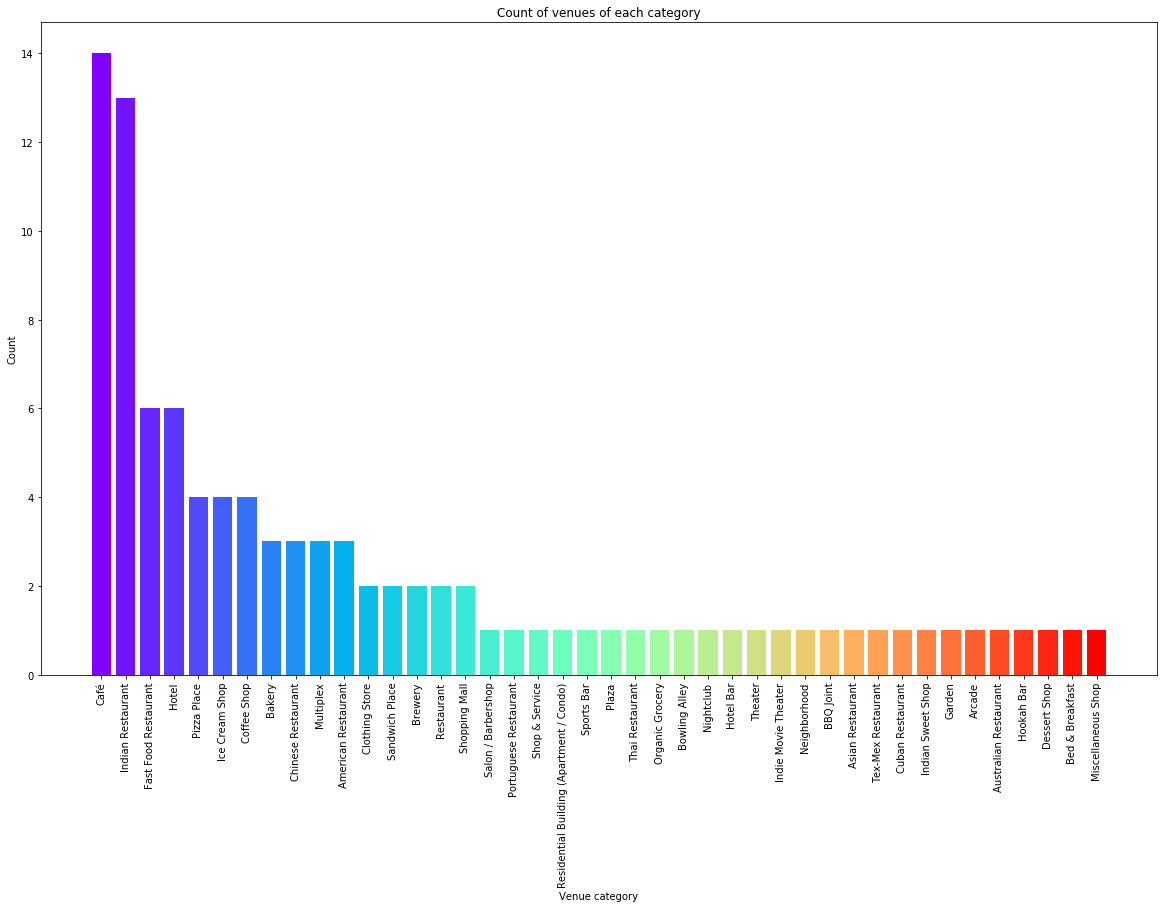

In [77]:
venue_distribution = venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category")
plt.ylabel("Count")
plt.title("Count of venues of each category")
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

In the complete list of venues, maximum venues are of type **Cafe** and **Indian Restaurant**.

## Get ratings and cost when available

I'll now use the Zomato API to fetch the rating as well as average cost for these locations (wherever available).

In [78]:
headers = {'user-key': ZOMATO_API_KEY}
venues_information = []

for index, row in venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
venues_information = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 'longitude', 'price_for_two', 'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [81]:
print("Information fetched for {} places".format(venues_information.shape[0]))

Information fetched for 99 places


To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round of both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [82]:
venues_information['latitude'] = venues_information['latitude'].apply(lambda lat: round(float(lat), 4))
venues_information['longitude'] = venues_information['longitude'].apply(lambda lng: round(float(lng), 4))
venues['lat'] = venues['lat'].apply(lambda lat: round(float(lat), 4))
venues['lng'] = venues['lng'].apply(lambda lng: round(float(lng), 4))

In [83]:
dataset = pd.concat([venues_information, venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

I'll now select the name from **Zomato API** and keep the venues that are same in both datasets based on the difference in the latitude and longitude values. I'll also get the average price per person by dividing the column `price_for_two` by 2 and removing this column from the dataset.

In [84]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'categories', 'lat_diff', 'lng_diff', 'price_for_two'])

Let's take a look at the final dataset that is left with us. I've also ensured that all venues are correct whenever two locations had similar venues, given I have knowledge of Chandigarh.

In [85]:
selected_venues.head(5)

,venue,latitude,longitude,price_range,rating,address,average_price
0,Nik Baker's,30.7216,76.7601,2.0,4.5,"SCO 441 - 442, Sector 35 C, Sector 35, Chandigarh",350.0
1,Starbucks Coffee,30.7298,76.7732,2.0,3.6,"Hotel Aquamarine, Sector 22C, Near Sector 22, ...",250.0
2,Barista,30.7222,76.7614,2.0,3.7,"SCO 422, Sector 35 C, Sector 35, Chandigarh",300.0
3,Peddlers,30.7208,76.7590,4.0,3.9,"Hotel Heritage, SCO 467 & 468, Sector 35 C, Se...",1100.0
4,Sundarams,30.7302,76.7735,1.0,3.4,"Hotel Aroma Complex, Himalaya Marg, Sector 22 ...",175.0


I'll drop the venues which have `0.0` rating as it means it's not been rated yet.

In [112]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 55


## Rating and price analysis

Now, I'll explore the venues based on their rating and price values.

### Rating

Let's explore the rating first.

In [113]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()

Text(0.5, 1.0, 'Count of venues with given rating')

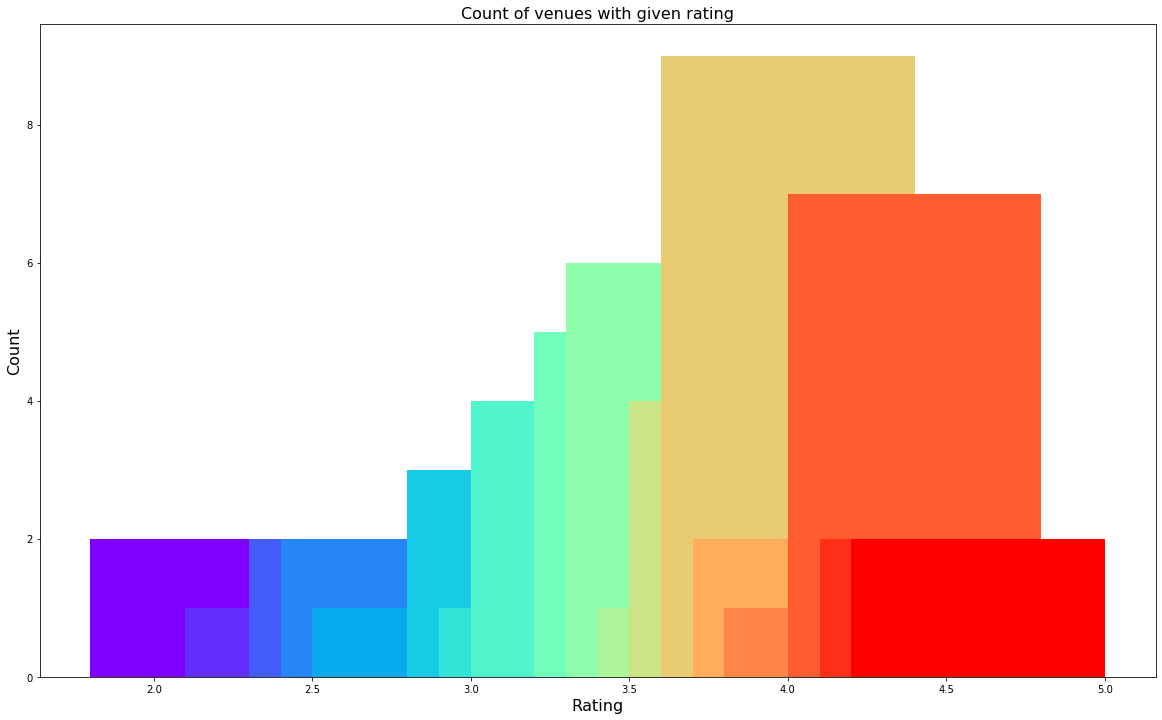

In [114]:
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that majority of the venues have their rating close to 4. Let's create bins for various ratings and plot them in different colors on the map.

In [115]:
bins = [0, 1, 2, 3, 4, 5]
labels = ['Bad', 'Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'], bins = bins, labels = labels, include_lowest = True)
selected_venues['rating_bin'] = selected_venues['rating_bin']

In [116]:
color_map = {'Bad': 'red', 'Low': 'lightred', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(chandigarh_map)  
    
chandigarh_map

Taking a look at the map reveals the location of all the venues. It appears that many venues are located near about **Sector 35** and **Elante Mall** with rating above 3. If someone wants to explore new venues, they should definitely check out Sector 35 or Elante Mall.

### Price

Let's take a look at the prices for various restaurants.

Text(0.5, 1.0, 'Count of venues with given average price')

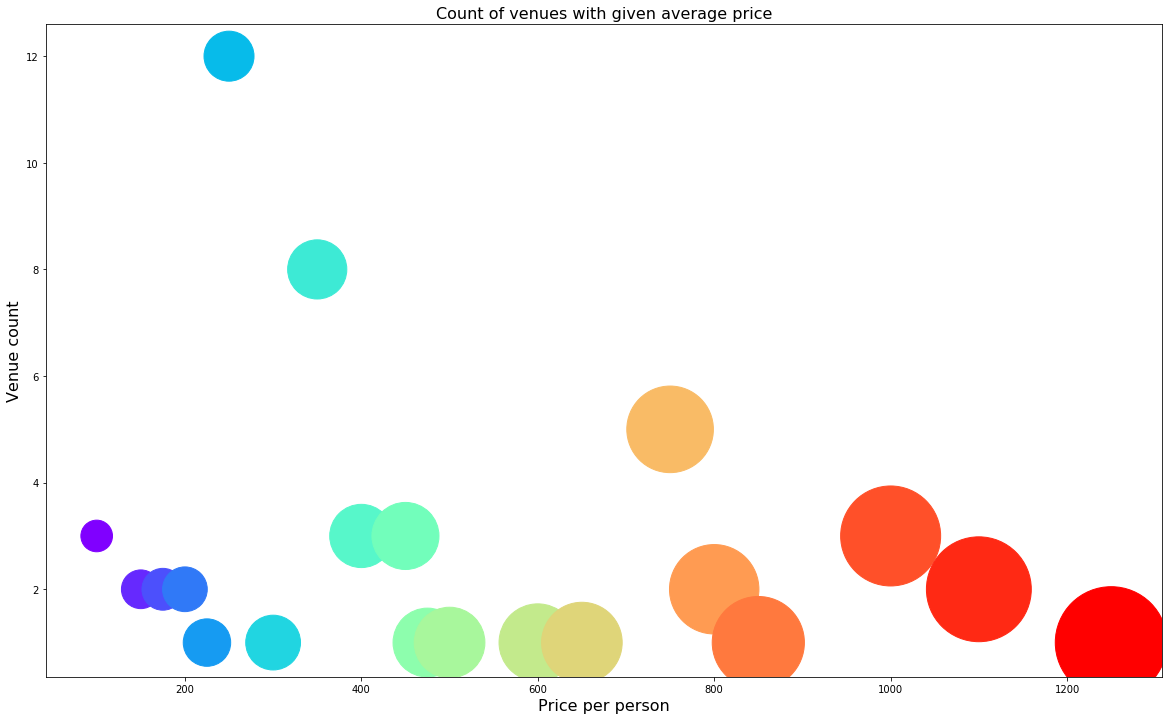

In [117]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

In the dataset, a large number of venues have an average price between Rs 200 and Rs 400.

Users might also be interested in going to a place that is not only rated high but also fits in their budget. I'll use the `price_range` column to plot the venues on a map.

In [118]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(chandigarh_map)  
    
chandigarh_map

1. The venues near Sector 35 are primarily lower priced.
2. The venues near Sector 7 and Sector 26 have steep prices.
3. Elante Mall seems to have a mix of both high priced and low priced venues.

## Clustering

I'll now cluster all these venues based on their price range, location and more.

In [119]:
NO_OF_CLUSTERS = 2
clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'cluster_labels'], 1)
selected_venues.drop(['cluster_labels'], 1, inplace = True)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Nik Baker's,30.7216,76.7601,2.0,4.5,"SCO 441 - 442, Sector 35 C, Sector 35, Chandigarh",350.0,Very good
1,0,Starbucks Coffee,30.7298,76.7732,2.0,3.6,"Hotel Aquamarine, Sector 22C, Near Sector 22, ...",250.0,Good
2,0,Barista,30.7222,76.7614,2.0,3.7,"SCO 422, Sector 35 C, Sector 35, Chandigarh",300.0,Good
3,1,Peddlers,30.7208,76.7590,4.0,3.9,"Hotel Heritage, SCO 467 & 468, Sector 35 C, Se...",1100.0,Good
4,0,Sundarams,30.7302,76.7735,1.0,3.4,"Hotel Aroma Complex, Himalaya Marg, Sector 22 ...",175.0,Good


In [120]:
chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)
color_map = { 0: 'red', 1: 'green'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(chandigarh_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(chandigarh_map)
       
chandigarh_map

From the map, we see the two clusters. 
1. The first cluster is spread across the whole city and includes the majority venues.
2. The second cluster is very sparsely spread and has very limited venues.

### Exploring venues in each cluster

I'll also check the venues of the two clusters.

In [128]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Nik Baker's,30.7216,76.7601,2.0,4.5,"SCO 441 - 442, Sector 35 C, Sector 35, Chandigarh",350.0,Very good
1,0,Starbucks Coffee,30.7298,76.7732,2.0,3.6,"Hotel Aquamarine, Sector 22C, Near Sector 22, ...",250.0,Good
2,0,Barista,30.7222,76.7614,2.0,3.7,"SCO 422, Sector 35 C, Sector 35, Chandigarh",300.0,Good
3,0,Sundarams,30.7302,76.7735,1.0,3.4,"Hotel Aroma Complex, Himalaya Marg, Sector 22 ...",175.0,Good
4,0,Classic 44,30.7149,76.7518,1.0,3.4,"SCO 413, Sector 44 D, Sector 44, Chandigarh",100.0,Good
5,0,Pizza Hut,30.7058,76.8012,2.0,3.6,"320, 3rd Floor, Elante Mall, Phase 1, Chandiga...",450.0,Good
6,0,Softy Corner,30.7405,76.7816,1.0,4.6,"SCO 87, Sector 17, Chandigarh",150.0,Very good
7,0,Pashtun,30.7247,76.7653,2.0,3.9,"SCO 333 & 334, Sector 35 B, Sector 35, Chandigarh",475.0,Good
8,0,FROYO - Frozen Yogurt & Treats,30.7235,76.7675,1.0,3.4,"2nd Floor, Piccadily Cinema, Sector 34, Chandi...",150.0,Good
9,0,Old Pal Dhaba,30.7194,76.8017,2.0,3.4,"Booth 165-166, Sector 28 D, Sector 28, Chandigarh",400.0,Good


In [129]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].mean()))

These venues have mean price range of 1.77 and rating spread around 3.59


In [131]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Peddlers,30.7208,76.7590,4.0,3.9,"Hotel Heritage, SCO 467 & 468, Sector 35 C, Se...",1100.0,Good
1,1,OvenFresh,30.7217,76.7604,3.0,4.6,"SCO 437 & 438, Sector 35 C, Sector 35, Chandigarh",800.0,Very good
2,1,Mainland China,30.7256,76.8052,3.0,4.1,"SCO 40, Madhya Marg, Sector 26, Chandigarh",750.0,Very good
3,1,The Brew Estate,30.7271,76.8038,4.0,4.4,"SCO 25, Madhya Marg, Sector 26, Chandigarh",1000.0,Very good
4,1,Virgin Courtyard,30.7348,76.7977,4.0,4.4,"SCO 1A, Backside, Madhya Marg, Sector 7C, Sect...",1100.0,Very good
5,1,The Brew Estate,30.7057,76.8006,4.0,4.4,"3rd Floor, #308, Elante Mall, Phase 1, Chandig...",1000.0,Very good
6,1,Cafe Nomad,30.7332,76.8032,3.0,3.9,"178, Inner Market, Sector 7, Chandigarh",750.0,Good
7,1,Cloud 9 - Hotel Shivalik View,30.7395,76.7767,3.0,3.7,"Hotel Shivalik View, Sector 17, Chandigarh",750.0,Good
8,1,Brooklyn Central,30.7052,76.8010,3.0,4.5,"51A, Courtyard, Ground Floor, Elante Mall, Pha...",650.0,Very good
9,1,Slounge - Lemon Tree Hotel,30.7055,76.8034,3.0,3.2,"Lemon Tree Hotel, Plot 3MW, Phase 1, Chandigar...",750.0,Good


In [133]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].mean()))

These venues have mean price range of 3.38 and rating spread around 4.02
